In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ohrc-slice-2/slice_x0_y19000.png
/kaggle/input/ohrc-slice/slice_x0_y10000.png
/kaggle/input/ohrc-images/ohrc2.png
/kaggle/input/ohrc-images/ohrc1.png


## **Image Processing Steps**:
  - Convert images to patches of 128x128 pixels.
  - Apply median filtering to reduce speckle noise (noting that SNR was decreasing in other methods but should have increased here).
  - Compare SNR between original images and speckle noise-free images.
  - Preprocess images for Horus:
    - Resize to 256x256 pixels.
    - Normalize the images.
    - Split into training and testing sets.
  - Use images after median filtering for training and original images for testing, comparing the Mean Absolute Error (MAE) for each pixel during model training.
  - Combine DestripeNet architecture and PhotonNet architecture for the Horus model, iterating through three sets of architectural adjustments.
  - Train the model using the prepared datasets.
  - Evaluate the model by testing it with a different image from another dataset.


In [8]:
import os
from PIL import Image

# Load the image
image_path = '/kaggle/input/ohrc-images/ohrc1.png'  # Replace with your image file path
image = Image.open(image_path)

# Create a directory to save the patches
output_dir = '/kaggle/working/output_images'
os.makedirs(output_dir, exist_ok=True)

# Calculate the number of patches that can fit
patch_size = 128
num_patches_x = image.size[0] // patch_size  # Number of patches horizontally
num_patches_y = image.size[1] // patch_size  # Number of patches vertically

# Extract patches and save them
for y in range(num_patches_y):
    for x in range(num_patches_x):
        left = x * patch_size
        upper = y * patch_size
        right = left + patch_size
        lower = upper + patch_size
        patch = image.crop((left, upper, right, lower))

        # Save the patch
        patch_path = os.path.join(output_dir, f'patch_{y}_{x}.png')
        patch.save(patch_path)

print(f'Patches saved in folder: {output_dir}')


Patches saved in folder: /kaggle/working/output_images


In [9]:
import os
from PIL import Image

# Load the image
image_path = '/kaggle/input/ohrc-images/ohrc2.png'  # Replace with your image file path
image = Image.open(image_path)

# Create a directory to save the patches
output_dir = '/kaggle/working/output_images'
os.makedirs(output_dir, exist_ok=True)

# Calculate the number of patches that can fit
patch_size = 128
num_patches_x = image.size[0] // patch_size  # Number of patches horizontally
num_patches_y = image.size[1] // patch_size  # Number of patches vertically

# Extract patches and save them
for y in range(num_patches_y):
    for x in range(num_patches_x):
        left = x * patch_size
        upper = y * patch_size
        right = left + patch_size
        lower = upper + patch_size
        patch = image.crop((left, upper, right, lower))

        # Save the patch
        patch_path = os.path.join(output_dir, f'patch_{y}_{x}.png')
        patch.save(patch_path)

print(f'Patches saved in folder: {output_dir}')

Patches saved in folder: /kaggle/working/output_images


In [10]:
# Clone the Real-ESRGAN repository
# !git clone https://github.com/xinntao/Real-ESRGAN.git

In [11]:
# # Upgrade torch and torchvision
# !pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# # Restart the kernel after this step

In [12]:
# # Install required packages
# !pip install --no-cache-dir basicsr facexlib gfpgan
# !pip install -r requirements.txt
# !python setup.py develop

In [13]:
# # Create a directory to store the weights
# !mkdir -p weights

# # Download the pre-trained model from the provided link
# !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth -P weights

In [14]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torchvision
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from sklearn.model_selection import train_test_split

# # Add the Real-ESRGAN path to the system path
# import sys
# sys.path.append('/kaggle/working/Real-ESRGAN')

# # Import the RealESRGANer class and RRDBNet architecture
# from realesrgan import RealESRGANer
# from basicsr.archs.rrdbnet_arch import RRDBNet

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation
from sklearn.model_selection import train_test_split

In [16]:
# Define the folder path
folder_path = '/kaggle/working/output_images'  

def load_images(folder_path):
    images = []
    filenames = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                filenames.append(filename)
    return images, filenames

original_images, filenames = load_images(folder_path)
if not original_images:
    print("No images found in the specified folder.")
else:
    print(f"Loaded {len(original_images)} images.")

Loaded 702 images.


In [17]:
def apply_median_filter(images, kernel_size=3):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img, kernel_size)
        filtered_images.append(filtered_img)
    return filtered_images

def calculate_snr(image):
    # Convert image to float32 
    image = image.astype(np.float32)
    
    # Compute the mean and standard deviation
    mean_signal = np.mean(image)
    std_noise = np.std(image)
    if std_noise == 0:
        return float('inf')
    # Calculate SNR in decibels
    snr = 20 * np.log10(mean_signal / std_noise)
    return snr

def calculate_and_print_snr(images, filtered_images, filenames):
    snr_before_list = []
    snr_after_list = []
    for idx in range(len(images)):
        original_image = images[idx]
        filtered_image = filtered_images[idx]
        # Calculate SNR before filtering
        snr_before = calculate_snr(original_image)
        snr_before_list.append(snr_before)
        # Calculate SNR after filtering
        snr_after = calculate_snr(filtered_image)
        snr_after_list.append(snr_after)
        
        print(f"Image: {filenames[idx]}")
        print(f"SNR Before Median Filtering: {snr_before:.2f} dB")
        print(f"SNR After Median Filtering: {snr_after:.2f} dB")
        print(f"SNR Change: {snr_after - snr_before:.2f} dB\n")
    
    # Calculate average SNR
    avg_snr_before = np.mean(snr_before_list)
    avg_snr_after = np.mean(snr_after_list)
    print(f"Average SNR Before Median Filtering: {avg_snr_before:.2f} dB")
    print(f"Average SNR After Median Filtering: {avg_snr_after:.2f} dB")
    print(f"Average SNR Change: {avg_snr_after - avg_snr_before:.2f} dB")

filtered_images = apply_median_filter(original_images)

calculate_and_print_snr(original_images, filtered_images, filenames)

Image: patch_0_0.png
SNR Before Median Filtering: 13.08 dB
SNR After Median Filtering: 15.21 dB
SNR Change: 2.13 dB

Image: patch_0_1.png
SNR Before Median Filtering: 12.45 dB
SNR After Median Filtering: 14.34 dB
SNR Change: 1.89 dB

Image: patch_0_2.png
SNR Before Median Filtering: 14.41 dB
SNR After Median Filtering: 16.74 dB
SNR Change: 2.33 dB

Image: patch_0_3.png
SNR Before Median Filtering: 14.43 dB
SNR After Median Filtering: 16.69 dB
SNR Change: 2.25 dB

Image: patch_0_4.png
SNR Before Median Filtering: 9.13 dB
SNR After Median Filtering: 10.04 dB
SNR Change: 0.91 dB

Image: patch_0_5.png
SNR Before Median Filtering: 10.74 dB
SNR After Median Filtering: 13.06 dB
SNR Change: 2.33 dB

Image: patch_0_6.png
SNR Before Median Filtering: 15.24 dB
SNR After Median Filtering: 18.79 dB
SNR Change: 3.55 dB

Image: patch_0_7.png
SNR Before Median Filtering: 11.50 dB
SNR After Median Filtering: 13.95 dB
SNR Change: 2.45 dB

Image: patch_0_8.png
SNR Before Median Filtering: 7.93 dB
SNR Aft

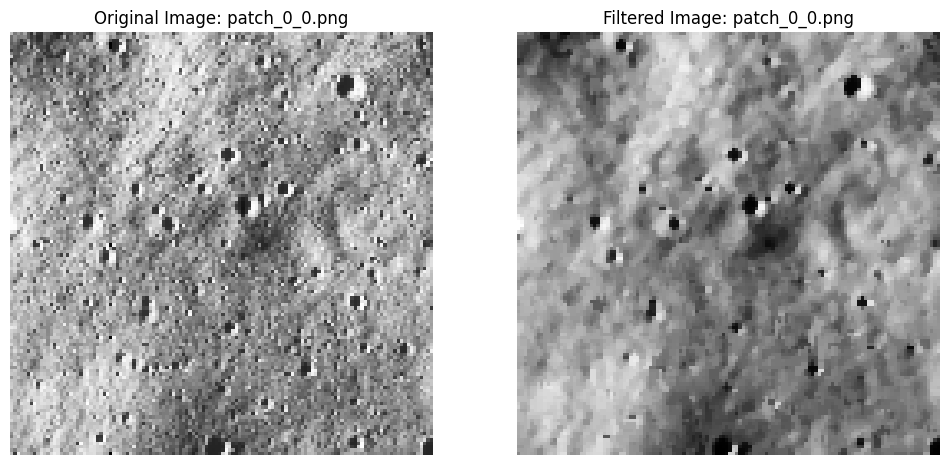

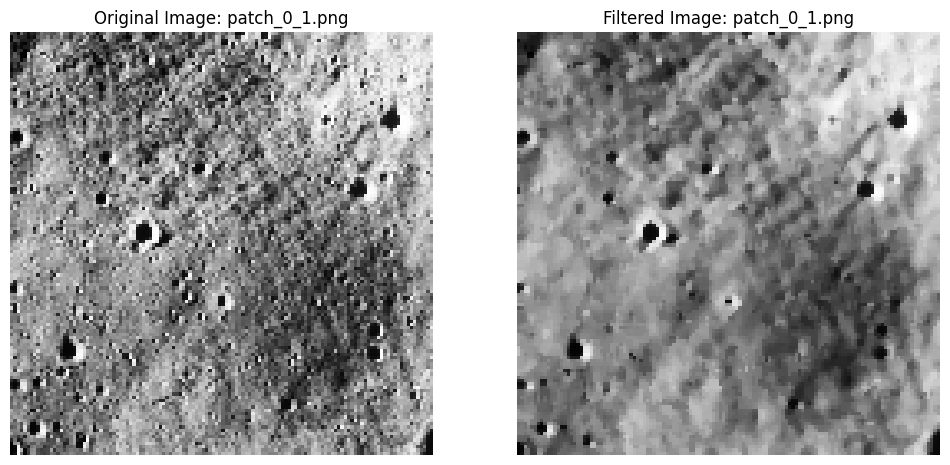

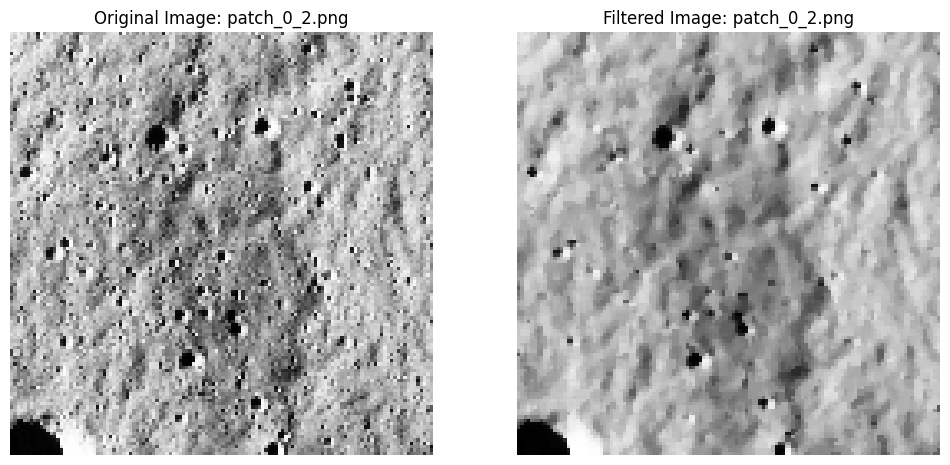

In [18]:
# Display the first 3 images before and after median filtering
num_images_to_display = min(3, len(original_images))

for idx in range(num_images_to_display):
    original_image = original_images[idx]
    filtered_image = filtered_images[idx]
    filename = filenames[idx]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original Image: {filename}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'Filtered Image: {filename}')
    plt.axis('off')
    
    plt.show()

### we take the median filter applied images as input whereas the original images are kept for the target images and ultimately, we compare the mae for each pixel value to train the model.

In [19]:
def preprocess_images(original_images, filtered_images):
    # Resize images 
    target_size = (256, 256)  
    resized_original_images = []
    resized_filtered_images = []
    for img_orig, img_filt in zip(original_images, filtered_images):
        img_orig_resized = cv2.resize(img_orig, target_size)
        img_filt_resized = cv2.resize(img_filt, target_size)
        resized_original_images.append(img_orig_resized)
        resized_filtered_images.append(img_filt_resized)
    
    X = np.array(resized_filtered_images, dtype=np.float32)
    y = np.array(resized_original_images, dtype=np.float32)
    
    X = X / 255.0
    y = y / 255.0
    
    if len(X.shape) == 3:
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)
            
    return X, y

X_train, y_train = preprocess_images(original_images, filtered_images)

print(f"Input shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")


Input shape: (702, 256, 256, 1)
Target shape: (702, 256, 256, 1)


In [20]:
def create_destripenet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional Blocks
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    skip1 = x  
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    skip2 = x 
    x = MaxPooling2D(pool_size=2)(x)
    
    # Bottleneck
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    
    # Upsampling Blocks
    x = UpSampling2D(size=2)(x)
    x = concatenate([x, skip2])
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)

    x = UpSampling2D(size=2)(x)
    x = concatenate([x, skip1])
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='DestripeNet')
    return model

In [21]:
def create_photonnet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Convolutional Blocks
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(x)
    skip1 = x  
    x = MaxPooling2D(pool_size=2)(x)
 
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    skip2 = x 
    x = MaxPooling2D(pool_size=2)(x)
    
    # Bottleneck
    x = Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
    
    # Upsampling Blocks
    x = UpSampling2D(size=2)(x)
    x = concatenate([x, skip2])
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
    
    x = UpSampling2D(size=2)(x)
    x = concatenate([x, skip1])
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(x)
    x = Conv2D(32, kernel_size=5, padding='same', activation='relu')(x)
    
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='PhotonNet')
    return model

In [22]:
def create_horus_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # DestripeNet branch
    destripenet = create_destripenet(input_shape)
    destripe_output = destripenet(inputs)
    
    # PhotonNet branch
    photonnet = create_photonnet(input_shape)
    photon_output = photonnet(inputs)
    
    # Combine the outputs of DestripeNet and PhotonNet
    combined = concatenate([destripe_output, photon_output], axis=-1)
    
    # Further processing
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(combined)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    
    # Create the HORUS model
    model = models.Model(inputs=inputs, outputs=outputs, name='HORUS')
    return model

In [23]:
# Create the HORUS model
input_shape = X_train.shape[1:]  # e.g., (256, 256, 1)
horus_model = create_horus_model(input_shape)

# Print the model summary
horus_model.summary()

Model: "HORUS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DestripeNet         │ (None, 256, 256,  │    470,977 │ input_layer_3[0]… │
│ (Functional)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhotonNet           │ (None, 256, 256,  │  1,307,073 │ input_layer_3[0]… │
│ (Functional)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 256, 256,  │          0 │ DestripeNet[0][0… │
│ (Concatenate)       │ 2)                │            │ PhotonNet[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 256, 256,  │      1,216 │ concatenate_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 256, 256,  │     18,464 │ conv2d_43[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 256, 256,  │         33 │ conv2d_44[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,797,763 (6.86 MB)

 Trainable params: 1,797,763 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:

def train_horus_model(model, X_train, y_train):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     checkpoint = 
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    history = model.fit(
        X_train_part, y_train_part,
        validation_data=(X_val, y_val),
        epochs=12,
        batch_size=4,
        callbacks=[early_stopping]
    )
    return history

history = train_horus_model(horus_model, X_train, y_train)

Epoch 1/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 338ms/step - loss: 0.0422 - mae: 0.1599 - val_loss: 0.0029 - val_mae: 0.0368
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 31s 217ms/step - loss: 0.0028 - mae: 0.0362 - val_loss: 0.0020 - val_mae: 0.0297
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0021 - mae: 0.0307 - val_loss: 0.0019 - val_mae: 0.0288
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0019 - mae: 0.0289 - val_loss: 0.0023 - val_mae: 0.0325
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0025 - mae: 0.0345 - val_loss: 0.0016 - val_mae: 0.0258
Epoch 6/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0017 - mae: 0.0263 - val_loss: 0.0017 - val_mae: 0.0256
Epoch 7/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 0.0016 - val_mae: 0.0248
Epoch 8/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 0.0016 - mae: 0.0250 - val_loss: 0.0019 - val_mae: 0.0289
Epoch 9/12
141/141 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
SNR Before HORUS Denoising: 13.55 dB
SNR After HORUS Denoising: 12.09 dB
SNR Improvement: -1.46 dB



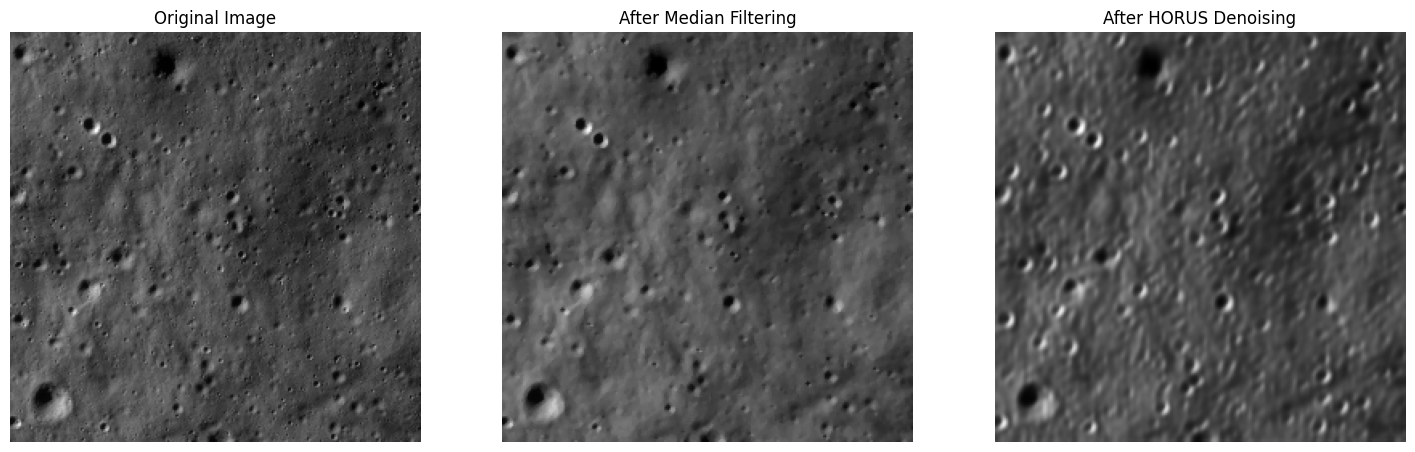

In [26]:
def denoise_new_image(model, image_path):
    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        raise ValueError("Image not found or unable to load.")
        
    # Resize the image to match the model input size
    target_size = (256, 256)  
    original_image_resized = cv2.resize(original_image, target_size)
    
    # Apply median filtering to remove speckle noise
    filtered_image = cv2.medianBlur(original_image_resized, 3)
    
    # Preprocess the image
    input_image = filtered_image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0) 
    input_image = np.expand_dims(input_image, axis=-1)  
    
    # Denoise using the model
    denoised_image = model.predict(input_image)
    denoised_image = denoised_image[0, :, :, 0]  
    denoised_image = np.clip(denoised_image * 255.0, 0, 255).astype(np.uint8)
    
    # Calculate SNR
    snr_before = calculate_snr(filtered_image)
    snr_after = calculate_snr(denoised_image)
    
    print(f"SNR Before HORUS Denoising: {snr_before:.2f} dB")
    print(f"SNR After HORUS Denoising: {snr_after:.2f} dB")
    print(f"SNR Improvement: {snr_after - snr_before:.2f} dB\n")
    
    # Display the images
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_resized, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('After Median Filtering')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('After HORUS Denoising')
    plt.axis('off')
    
    plt.show()
    
    return denoised_image

new_image_path = '/kaggle/input/ohrc-slice-2/slice_x0_y19000.png'
denoised_image = denoise_new_image(horus_model, new_image_path)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.0000e+00 - loss: 0.5843
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.0000e+00 - loss: 0.5365
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.0000e+00 - loss: 0.5359
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0000e+00 - loss: 0.5399
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0000e+00 - loss: 0.5397
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0000e+00 - loss: 0.5364
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.0000e+00 - loss: 0.5327
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0000e+00 - loss: 0.5313
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.0000e+00 - loss: 0.5334
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.0000e+00 - loss: 0.5361


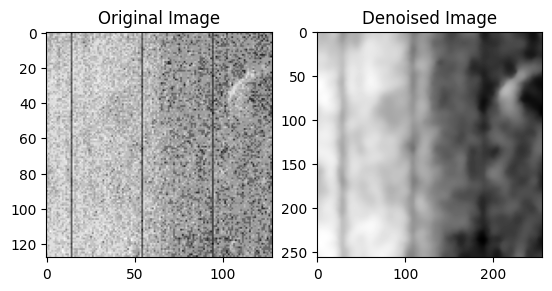

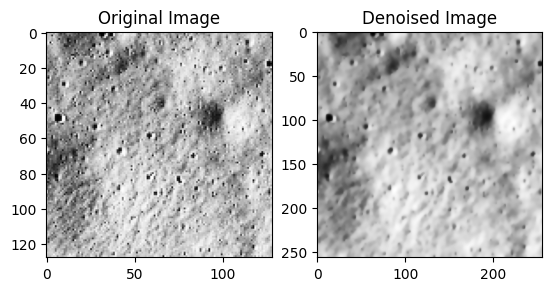

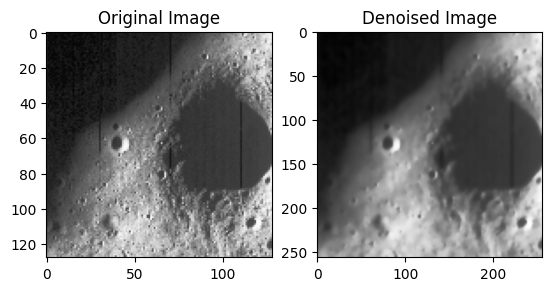

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Step 1: Data Acquisition and Preprocessing

# Function to load images from a folder
def load_images_from_folder(folder_path):
    images = []
    filenames = os.listdir(folder_path)
    for filename in filenames:
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Preprocessing step: apply wavelet denoising and total variation denoising
def preprocess_images(images):
    preprocessed_images = []
    for img in images:
        # Resize image to 256x256
        img_resized = cv2.resize(img, (256, 256))
        
        # Apply wavelet denoising
        denoised_img_wavelet = denoise_wavelet(img_resized, channel_axis=None)
        # Apply total variation denoising
        denoised_img_tv = denoise_tv_chambolle(denoised_img_wavelet, weight=0.1)
        preprocessed_images.append(denoised_img_tv)
    return preprocessed_images

# Step 2: Custom Model Implementation (U-Net)

# Define U-Net architecture for image enhancement
def unet_model(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(pool2)
    up1 = layers.concatenate([up1, conv2])
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv3)
    up2 = layers.concatenate([up2, conv1])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv4)
    
    model = models.Model(inputs, outputs)
    return model

# Step 3: Data Fusion Simulation (for future use)

# Simulate additional data sources
def integrate_data_sources(primary_images, additional_data):
    # Placeholder: Just pass through primary images for now
    integrated_data = primary_images
    return integrated_data

# Step 4: Putting It All Together

# Folder path to your images
folder_path = "/kaggle/working/output_images"

# Load images
images = load_images_from_folder(folder_path)

# Preprocess images with denoising (wavelet + TV denoising)
preprocessed_images = preprocess_images(images)

# Simulate data integration (optional, placeholder)
additional_data = []  # Placeholder for other data sources
integrated_images = integrate_data_sources(preprocessed_images, additional_data)

# Define U-Net model
input_shape = (256, 256, 1)  # Modify based on your image size
unet = unet_model(input_shape)
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming you have prepared X_train and y_train for the U-Net model
X_train = np.array(integrated_images)
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension
y_train = X_train  # Using X_train as the output in unsupervised learning

# Train U-Net (you can modify epochs and batch size)
unet.fit(X_train, y_train, epochs=10, batch_size=4)

# Step 5: Plot the Results

# Plot original and denoised images
for i in range(3):  # Display first 3 processed images
    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_images[i], cmap='gray')
    plt.title('Denoised Image')
    
    plt.show()